# 04 - Model Optimization: Feature Selection, Tuning & Ensemble

This notebook optimizes the price prediction model through:

1. **Feature Importance Analysis** - Identify and remove unimportant features
2. **User Input Considerations** - Which features are easy for users to provide?
3. **Additional Models** - XGBoost, LightGBM
4. **Hyperparameter Tuning** - Optuna optimization for top models (optimizing MAE)
5. **Ensemble Methods** - Stacking and weighted averaging
6. **Final Model Selection** - Best single model vs ensemble

**Primary Metric: MAE (Mean Absolute Error)** - More robust to outliers than RMSE

---

## 1. Imports and Setup

In [3]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import warnings
from pathlib import Path

# Add src to path
sys.path.append('..')

# Reload modules
for mod in list(sys.modules.keys()):
    if 'src.' in mod or mod in ['modeling', 'features']:
        del sys.modules[mod]

from src.modeling import (
    build_sklearn_pipeline,
    build_catboost_model,
    prepare_catboost_data,
    evaluate_sklearn_cv,
    evaluate_predictions,
    compare_models,
    save_model,
    build_preprocessor,
    CATBOOST_AVAILABLE,
    XGBOOST_AVAILABLE,
    LIGHTGBM_AVAILABLE
)
from src.features import get_feature_columns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.inspection import permutation_importance
from sklearn.ensemble import StackingRegressor, VotingRegressor
from sklearn.linear_model import Ridge

# Display settings
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', '{:.2f}'.format)
sns.set_theme(style='whitegrid')
warnings.filterwarnings('ignore')

print("Core libraries loaded!")
print(f"CatBoost available: {CATBOOST_AVAILABLE}")
print(f"XGBoost available: {XGBOOST_AVAILABLE}")
print(f"LightGBM available: {LIGHTGBM_AVAILABLE}")

Core libraries loaded!
CatBoost available: True
XGBoost available: True
LightGBM available: True


In [4]:
# Check for optional libraries (Optuna and SHAP)
# XGBoost and LightGBM availability already checked via src.modeling

try:
    import optuna
    from optuna.samplers import TPESampler  # Import TPESampler
    OPTUNA_AVAILABLE = True
    print(f"Optuna available: {OPTUNA_AVAILABLE} (version {optuna.__version__})")
except ImportError:
    OPTUNA_AVAILABLE = False
    print("Optuna not available. Install with: pip install optuna")

try:
    import shap
    SHAP_AVAILABLE = True
    print(f"SHAP available: {SHAP_AVAILABLE}")
except ImportError:
    SHAP_AVAILABLE = False
    print("SHAP not available. Install with: pip install shap")

Optuna available: True (version 4.6.0)
SHAP available: True


## 2. Load Data

In [5]:
DATA_DIR = Path('../data')
TARGET_COL = '_precio_num'

# Load processed features (already has 1-99th percentile outlier removal applied)
try:
    df = pd.read_parquet(DATA_DIR / 'db_features.parquet')
    print("Loaded from parquet")
except (ImportError, FileNotFoundError):
    df = pd.read_csv(DATA_DIR / 'db_features.csv')
    print("Loaded from CSV")

print(f"\nDataset shape: {df.shape}")
print(f"Rows: {len(df):,}")
print(f"Columns: {len(df.columns)}")

# Show price range to confirm outlier removal was applied
price_min = df[TARGET_COL].min()
price_max = df[TARGET_COL].max()
print(f"\nPrice range: €{price_min:,.0f} - €{price_max:,.0f}")
print("(Note: Data from notebook 02/03 already has 1-99th percentile outlier removal)")

Loaded from CSV

Dataset shape: (7767, 63)
Rows: 7,767
Columns: 63

Price range: €222 - €6,070
(Note: Data from notebook 02/03 already has 1-99th percentile outlier removal)


In [6]:
# Get feature types
feature_cols, numeric_cols, categorical_cols = get_feature_columns(df, TARGET_COL)

print(f"Total features: {len(feature_cols)}")
print(f"  Numeric: {len(numeric_cols)}")
print(f"  Categorical: {len(categorical_cols)}")

print(f"\nNumeric features:")
for col in numeric_cols:
    print(f"  - {col}")

print(f"\nCategorical features:")
for col in categorical_cols:
    print(f"  - {col}")

Total features: 62
  Numeric: 20
  Categorical: 42

Numeric features:
  - _resolucion_pixeles
  - _gpu_value
  - _gpu_price_usd
  - Otras características_Fecha de lanzamiento
  - _tiene_webcam
  - _tamano_pantalla_pulgadas
  - _version_bluetooth
  - _peso_kg
  - _cpu_price_usd
  - _cpu_value
  - Disco duro_Número de discos duros (instalados)
  - _cpu_cores
  - _gpu_rank
  - _gpu_mark
  - _ssd_gb
  - _ram_gb
  - _cpu_mark
  - _cpu_rank
  - _tiene_bluetooth
  - _tiene_wifi

Categorical features:
  - Pantalla_Resolución de pantalla
  - Comunicaciones_Estándar LAN
  - Sistema operativo_Arquitectura bit
  - Alimentación_Vatios-hora
  - gpu_series
  - Pantalla_Formato de imagen
  - Medidas y peso_Diseño
  - Cámara_Webcam
  - Comunicaciones_Estándar wifi
  - Medidas y peso_Altura
  - Pantalla_Diagonal de la pantalla
  - Pantalla_Tamaño de la pantalla
  - Almacenamiento_Lector óptico
  - Comunicaciones_Versión Bluetooth
  - Medidas y peso_Peso
  - _serie
  - Procesador_Frecuencia de reloj
  - 

In [7]:
# Prepare train/test split
X = df[feature_cols].copy()
y = df[TARGET_COL].copy()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Train: {len(X_train):,} samples")
print(f"Test: {len(X_test):,} samples")

Train: 6,213 samples
Test: 1,554 samples


## 3. Feature Importance Analysis (CatBoost)

We use CatBoost (our best performing model) for feature importance analysis:
1. **CatBoost Native Importance** - Built-in feature importance from the model
2. **Permutation Importance** - Model-agnostic, reliable measure
3. **SHAP Values** - For detailed interpretability

In [8]:
# Train CatBoost for feature importance analysis (our best model)
if CATBOOST_AVAILABLE:
    from catboost import CatBoostRegressor
    
    print("Training CatBoost for feature importance analysis...")
    
    # Prepare CatBoost data
    X_cb, y_cb = prepare_catboost_data(df, numeric_cols, categorical_cols, TARGET_COL)
    X_cb_train, X_cb_test, y_cb_train, y_cb_test = train_test_split(
        X_cb, y_cb, test_size=0.2, random_state=42
    )
    
    # Train CatBoost
    cat_baseline = CatBoostRegressor(
        iterations=300,
        depth=6,
        learning_rate=0.1,
        cat_features=categorical_cols,
        random_seed=42,
        verbose=False
    )
    cat_baseline.fit(X_cb_train, y_cb_train)
    
    y_pred = cat_baseline.predict(X_cb_test)
    baseline_metrics = evaluate_predictions(y_cb_test, y_pred)
    
    print(f"\nBaseline Performance (CatBoost, all features):")
    print(f"  RMSE: {baseline_metrics['rmse']:,.2f}")
    print(f"  MAE:  {baseline_metrics['mae']:,.2f}")
    print(f"  R²:   {baseline_metrics['r2']:.4f}")
else:
    print("CatBoost not available - using HistGradientBoosting instead")
    hgb_pipeline = build_sklearn_pipeline('hist_gradient_boosting', numeric_cols, categorical_cols)
    hgb_pipeline.fit(X_train, y_train)
    y_pred = hgb_pipeline.predict(X_test)
    baseline_metrics = evaluate_predictions(y_test, y_pred)
    print(f"\nBaseline Performance (HGB, all features):")
    print(f"  RMSE: {baseline_metrics['rmse']:,.2f}")

Training CatBoost for feature importance analysis...

Baseline Performance (CatBoost, all features):
  RMSE: 427.34
  MAE:  265.53
  R²:   0.8023


In [9]:
# Feature Importance using CatBoost's native importance + Permutation Importance
if CATBOOST_AVAILABLE:
    print("Computing CatBoost feature importance...")
    
    # Method 1: CatBoost's native feature importance (fast)
    native_importance = cat_baseline.get_feature_importance()
    
    # Method 2: Permutation importance (more reliable but slower)
    print("Computing permutation importance (this may take a few minutes)...")
    perm_importance = permutation_importance(
        cat_baseline, X_cb_test, y_cb_test,
        n_repeats=10,
        random_state=42,
        n_jobs=-1
    )
    
    # Create importance DataFrame combining both methods
    importance_df = pd.DataFrame({
        'feature': feature_cols,
        'native_importance': native_importance,
        'importance_mean': perm_importance.importances_mean,
        'importance_std': perm_importance.importances_std
    }).sort_values('importance_mean', ascending=False)
    
    print("\n=== CatBoost Feature Importance (Top 20) ===")
    display(importance_df.head(20))
else:
    # Fallback to sklearn permutation importance
    print("Computing permutation importance with HGB...")
    perm_importance = permutation_importance(
        hgb_pipeline, X_test, y_test,
        n_repeats=10, random_state=42, n_jobs=-1
    )
    importance_df = pd.DataFrame({
        'feature': feature_cols,
        'importance_mean': perm_importance.importances_mean,
        'importance_std': perm_importance.importances_std
    }).sort_values('importance_mean', ascending=False)
    display(importance_df.head(20))

Computing CatBoost feature importance...
Computing permutation importance (this may take a few minutes)...

=== CatBoost Feature Importance (Top 20) ===


,feature,native_importance,importance_mean,importance_std
35,Medidas y peso_Ancho,20.86,0.13,0.01
15,Pantalla_Diagonal de la pantalla,5.62,0.04,0.00
25,_cpu_value,3.04,0.03,0.00
2,Comunicaciones_Estándar LAN,5.70,0.03,0.00
61,_brand,3.65,0.03,0.00
58,_tiene_bluetooth,3.56,0.02,0.00
23,_serie,3.19,0.02,0.00
17,_tamano_pantalla_pulgadas,4.66,0.02,0.00
21,_peso_kg,1.95,0.02,0.00
13,Comunicaciones_Estándar wifi,4.35,0.01,0.00


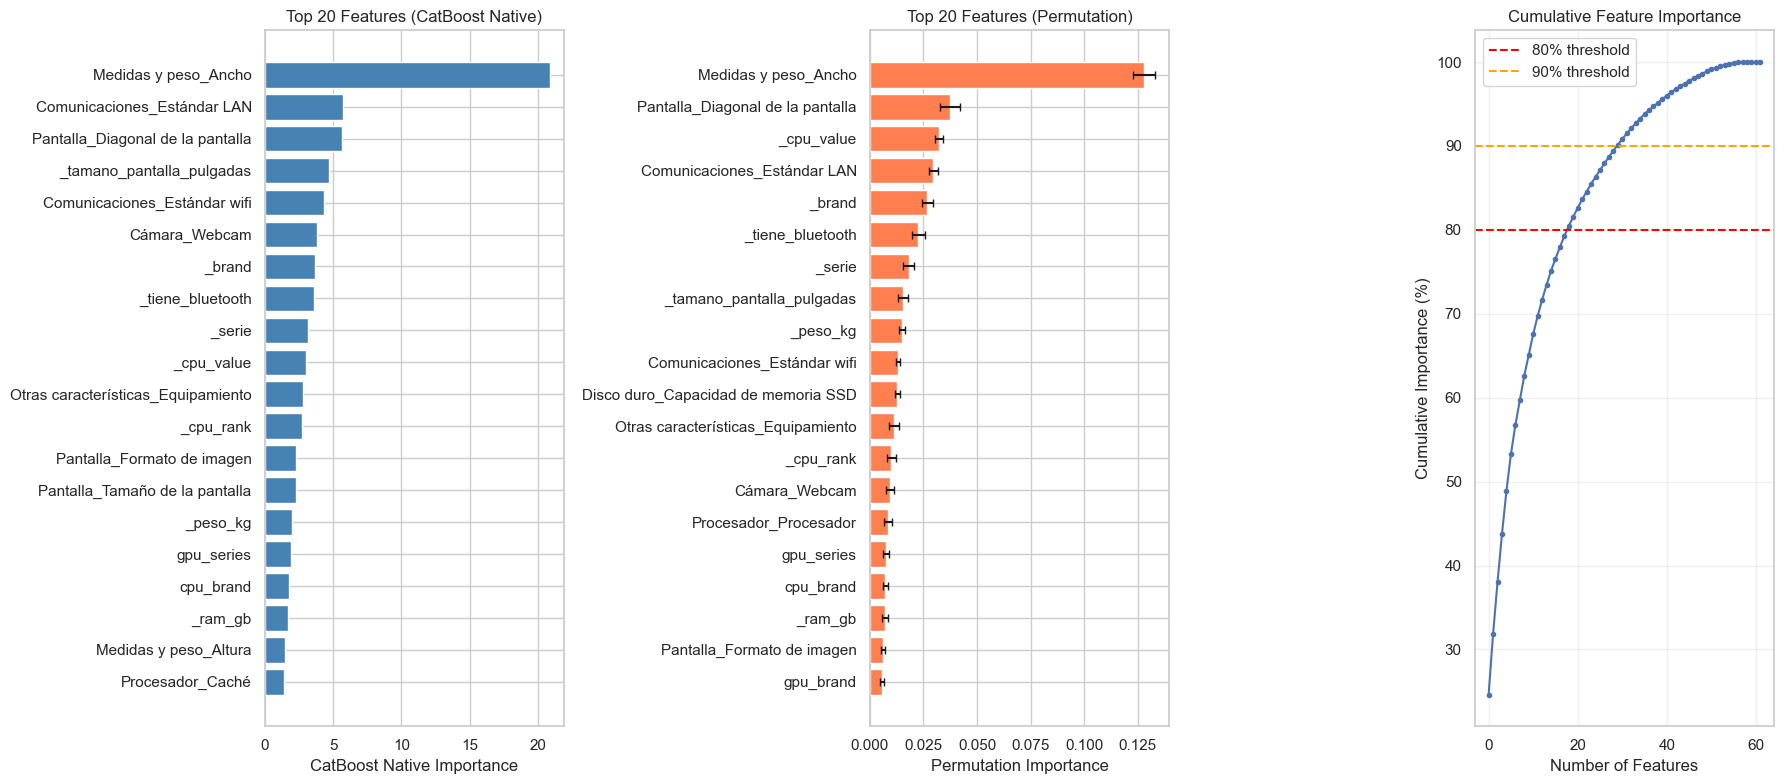


Features needed for 80% cumulative importance: 19
Features needed for 90% cumulative importance: 30


In [10]:
# Visualize feature importance (CatBoost native + permutation)
fig, axes = plt.subplots(1, 3 if CATBOOST_AVAILABLE else 2, figsize=(18 if CATBOOST_AVAILABLE else 14, 8))

top_n = 20
top_features = importance_df.head(top_n)

# Native importance (CatBoost only)
if CATBOOST_AVAILABLE:
    ax = axes[0]
    top_native = importance_df.nlargest(top_n, 'native_importance')
    ax.barh(range(top_n), top_native['native_importance'], color='steelblue')
    ax.set_yticks(range(top_n))
    ax.set_yticklabels(top_native['feature'])
    ax.set_xlabel('CatBoost Native Importance')
    ax.set_title(f'Top {top_n} Features (CatBoost Native)')
    ax.invert_yaxis()
    perm_ax_idx = 1
else:
    perm_ax_idx = 0

# Permutation importance
ax = axes[perm_ax_idx]
ax.barh(range(top_n), top_features['importance_mean'], 
        xerr=top_features['importance_std'], capsize=3, color='coral')
ax.set_yticks(range(top_n))
ax.set_yticklabels(top_features['feature'])
ax.set_xlabel('Permutation Importance')
ax.set_title(f'Top {top_n} Features (Permutation)')
ax.invert_yaxis()

# Cumulative importance
ax = axes[perm_ax_idx + 1]
importance_df_sorted = importance_df.sort_values('importance_mean', ascending=False)
importance_df_sorted['cumulative'] = importance_df_sorted['importance_mean'].cumsum()
importance_df_sorted['cumulative_pct'] = importance_df_sorted['cumulative'] / importance_df_sorted['importance_mean'].sum() * 100

ax.plot(range(len(importance_df_sorted)), importance_df_sorted['cumulative_pct'], marker='o', markersize=3)
ax.axhline(80, color='red', linestyle='--', label='80% threshold')
ax.axhline(90, color='orange', linestyle='--', label='90% threshold')
ax.set_xlabel('Number of Features')
ax.set_ylabel('Cumulative Importance (%)')
ax.set_title('Cumulative Feature Importance')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Find how many features for 80% and 90% importance
n_80 = (importance_df_sorted['cumulative_pct'] <= 80).sum() + 1
n_90 = (importance_df_sorted['cumulative_pct'] <= 90).sum() + 1
print(f"\nFeatures needed for 80% cumulative importance: {n_80}")
print(f"Features needed for 90% cumulative importance: {n_90}")

In [11]:
# Identify features with near-zero or negative importance
low_importance = importance_df[importance_df['importance_mean'] <= 0]
print(f"\n=== Features with Zero/Negative Importance ({len(low_importance)}) ===")
if len(low_importance) > 0:
    display(low_importance)
else:
    print("No features with zero/negative importance")


=== Features with Zero/Negative Importance (2) ===


,feature,native_importance,importance_mean,importance_std
4,Alimentación_Vatios-hora,0.00,0.00,0.00
60,Tipo,0.00,0.00,0.00


### 3.1 SHAP Values (if available)

Computing SHAP values with CatBoost...


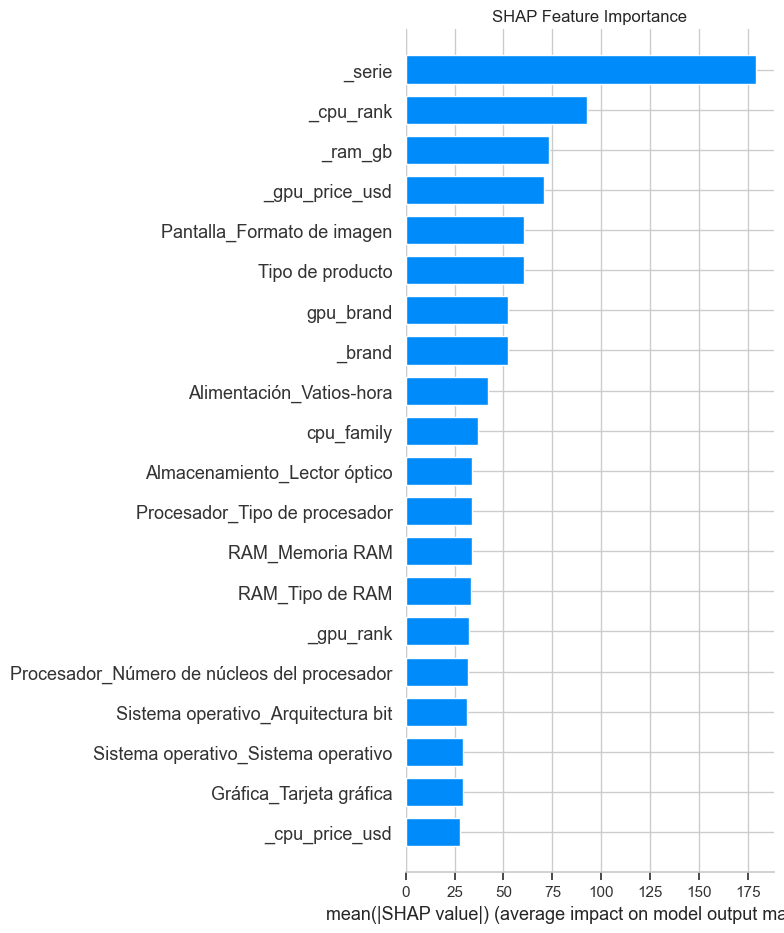

In [12]:
if SHAP_AVAILABLE and CATBOOST_AVAILABLE:
    print("Computing SHAP values with CatBoost...")
    
    # Prepare CatBoost data
    X_cb, y_cb = prepare_catboost_data(df, numeric_cols, categorical_cols, TARGET_COL)
    X_cb_train, X_cb_test, y_cb_train, y_cb_test = train_test_split(
        X_cb, y_cb, test_size=0.2, random_state=42
    )
    
    # Train CatBoost
    cat_model = build_catboost_model(categorical_cols, loss_function='RMSE')
    cat_model.fit(X_cb_train, y_cb_train)
    
    # Compute SHAP values (use sample for speed)
    sample_size = min(500, len(X_cb_test))
    X_sample = X_cb_test.sample(sample_size, random_state=42)
    
    explainer = shap.TreeExplainer(cat_model)
    shap_values = explainer.shap_values(X_sample)
    
    # Summary plot
    plt.figure(figsize=(12, 8))
    shap.summary_plot(shap_values, X_sample, plot_type="bar", show=False)
    plt.title("SHAP Feature Importance")
    plt.tight_layout()
    plt.show()
else:
    print("SHAP or CatBoost not available - skipping SHAP analysis")

## 4. User Input Feature Analysis

Categorize features by how easy they are for users to provide:
- **Easy**: Users know these directly (RAM, SSD, brand, screen size)
- **Medium**: Users can look up or select from dropdown (CPU family, GPU series, screen type)
- **Hard**: Requires backend lookup (benchmark scores, prices)

In [13]:
# Categorize features by user input difficulty
user_easy_features = [
    '_ram_gb',
    '_ssd_gb', 
    '_brand',
    '_tamano_pantalla_pulgadas',
    '_peso_kg',
    '_cpu_cores',
    '_tiene_wifi',
    '_tiene_bluetooth',
    '_tiene_webcam',
]

user_medium_features = [
    'cpu_brand',
    'cpu_family',
    'gpu_brand',
    'gpu_series',
    'gpu_is_integrated',
    '_serie',
    '_resolucion_pixeles',
    '_tasa_refresco_hz',
    '_gpu_memory_gb',
    # Screen technology columns (if present)
    'Pantalla_Tecnología de la pantalla',
]

user_hard_features = [
    # CPU benchmark features (require backend lookup)
    '_cpu_mark',
    '_cpu_rank',
    '_cpu_value',
    '_cpu_price_usd',
    # GPU benchmark features (require backend lookup)
    '_gpu_mark',
    '_gpu_rank',
    '_gpu_value',
    '_gpu_price_usd',
]

# Filter to only features that exist in our dataset
user_easy_features = [f for f in user_easy_features if f in feature_cols]
user_medium_features = [f for f in user_medium_features if f in feature_cols]
user_hard_features = [f for f in user_hard_features if f in feature_cols]

print("=== Feature Categorization for User Input ===")
print(f"\nEASY (user knows directly): {len(user_easy_features)}")
for f in user_easy_features:
    imp = importance_df[importance_df['feature'] == f]['importance_mean'].values
    imp_val = imp[0] if len(imp) > 0 else 0
    print(f"  - {f}: importance={imp_val:.4f}")

print(f"\nMEDIUM (dropdown/lookup): {len(user_medium_features)}")
for f in user_medium_features:
    imp = importance_df[importance_df['feature'] == f]['importance_mean'].values
    imp_val = imp[0] if len(imp) > 0 else 0
    print(f"  - {f}: importance={imp_val:.4f}")

print(f"\nHARD (backend lookup needed): {len(user_hard_features)}")
for f in user_hard_features:
    imp = importance_df[importance_df['feature'] == f]['importance_mean'].values
    imp_val = imp[0] if len(imp) > 0 else 0
    print(f"  - {f}: importance={imp_val:.4f}")

=== Feature Categorization for User Input ===

EASY (user knows directly): 9
  - _ram_gb: importance=0.0070
  - _ssd_gb: importance=0.0049
  - _brand: importance=0.0268
  - _tamano_pantalla_pulgadas: importance=0.0154
  - _peso_kg: importance=0.0151
  - _cpu_cores: importance=0.0023
  - _tiene_wifi: importance=0.0017
  - _tiene_bluetooth: importance=0.0225
  - _tiene_webcam: importance=0.0023

MEDIUM (dropdown/lookup): 7
  - cpu_brand: importance=0.0072
  - cpu_family: importance=0.0031
  - gpu_brand: importance=0.0057
  - gpu_series: importance=0.0076
  - gpu_is_integrated: importance=0.0042
  - _serie: importance=0.0180
  - _resolucion_pixeles: importance=0.0013

HARD (backend lookup needed): 8
  - _cpu_mark: importance=0.0018
  - _cpu_rank: importance=0.0100
  - _cpu_value: importance=0.0322
  - _cpu_price_usd: importance=0.0053
  - _gpu_mark: importance=0.0015
  - _gpu_rank: importance=0.0016
  - _gpu_value: importance=0.0013
  - _gpu_price_usd: importance=0.0021


In [14]:
# Create feature sets for different model versions
# Full model: All features
# Lite model: Easy + Medium features only (no backend lookup)

lite_features = user_easy_features + user_medium_features
lite_numeric = [f for f in lite_features if f in numeric_cols]
lite_categorical = [f for f in lite_features if f in categorical_cols]

print(f"\n=== Feature Sets ===")
print(f"Full model: {len(feature_cols)} features")
print(f"Lite model: {len(lite_features)} features (no benchmark lookups)")
print(f"  - Numeric: {len(lite_numeric)}")
print(f"  - Categorical: {len(lite_categorical)}")


=== Feature Sets ===
Full model: 62 features
Lite model: 16 features (no benchmark lookups)
  - Numeric: 9
  - Categorical: 7


In [15]:
# Compare Full vs Lite model performance using CatBoost
print("\n=== Comparing Full vs Lite Model (CatBoost) ===")

if CATBOOST_AVAILABLE:
    from catboost import CatBoostRegressor
    
    # Full model (already trained above as cat_baseline)
    print("\nFull model (all features):")
    full_cv_scores = cross_val_score(
        CatBoostRegressor(iterations=300, depth=6, learning_rate=0.1,
                          cat_features=categorical_cols, random_seed=42, verbose=False),
        X_cb_train, y_cb_train, cv=5, scoring='neg_root_mean_squared_error'
    )
    full_rmse = -full_cv_scores.mean()
    print(f"  RMSE: {full_rmse:,.2f}")
    
    # Lite model (user-friendly features only)
    if len(lite_features) > 0:
        print("\nLite model (user-friendly features only):")
        
        # Prepare lite CatBoost data
        lite_df = df[lite_features + [TARGET_COL]].copy()
        X_cb_lite, y_cb_lite = prepare_catboost_data(
            lite_df, lite_numeric, lite_categorical, TARGET_COL
        )
        X_cb_lite_train, _, y_cb_lite_train, _ = train_test_split(
            X_cb_lite, y_cb_lite, test_size=0.2, random_state=42
        )
        
        lite_cv_scores = cross_val_score(
            CatBoostRegressor(iterations=300, depth=6, learning_rate=0.1,
                              cat_features=lite_categorical, random_seed=42, verbose=False),
            X_cb_lite_train, y_cb_lite_train, cv=5, scoring='neg_root_mean_squared_error'
        )
        lite_rmse = -lite_cv_scores.mean()
        print(f"  RMSE: {lite_rmse:,.2f}")
        
        # Performance difference
        rmse_increase = (lite_rmse - full_rmse) / full_rmse * 100
        print(f"\nPerformance difference:")
        print(f"  RMSE increase: {rmse_increase:+.1f}%")
        print(f"  (Lite model uses {len(lite_features)} features vs {len(feature_cols)} in full model)")
else:
    # Fallback to HGB if CatBoost not available
    print("CatBoost not available - using HistGradientBoosting")
    full_pipeline = build_sklearn_pipeline('hist_gradient_boosting', numeric_cols, categorical_cols)
    full_results = evaluate_sklearn_cv(full_pipeline, X_train, y_train, cv=5)
    print(f"Full Model - RMSE: {full_results['rmse_mean']:,.2f}")


=== Comparing Full vs Lite Model (CatBoost) ===

Full model (all features):
  RMSE: 469.97

Lite model (user-friendly features only):
  RMSE: 531.81

Performance difference:
  RMSE increase: +13.2%
  (Lite model uses 16 features vs 62 in full model)


## 5. Feature Selection

Select top features based on importance analysis.

In [16]:
# Select features with positive importance
important_features = importance_df[importance_df['importance_mean'] > 0]['feature'].tolist()

# Or select top N features
TOP_N_FEATURES = min(30, len(important_features))  # Adjust as needed
top_features_list = importance_df.head(TOP_N_FEATURES)['feature'].tolist()

print(f"\n=== Feature Selection ===")
print(f"Features with positive importance: {len(important_features)}")
print(f"Selected top {TOP_N_FEATURES} features for optimization")

# Split into numeric and categorical
selected_numeric = [f for f in top_features_list if f in numeric_cols]
selected_categorical = [f for f in top_features_list if f in categorical_cols]

print(f"  - Numeric: {len(selected_numeric)}")
print(f"  - Categorical: {len(selected_categorical)}")

# Prepare selected feature data
X_train_selected = X_train[top_features_list]
X_test_selected = X_test[top_features_list]


=== Feature Selection ===
Features with positive importance: 60
Selected top 30 features for optimization
  - Numeric: 9
  - Categorical: 21


In [17]:
# Verify performance with selected features using CatBoost
print("\nVerifying performance with selected features (CatBoost)...")

if CATBOOST_AVAILABLE:
    # Prepare selected feature data for CatBoost
    selected_df = df[top_features_list + [TARGET_COL]].copy()
    X_cb_selected, y_cb_selected = prepare_catboost_data(
        selected_df, selected_numeric, selected_categorical, TARGET_COL
    )
    X_cb_sel_train, X_cb_sel_test, y_cb_sel_train, y_cb_sel_test = train_test_split(
        X_cb_selected, y_cb_selected, test_size=0.2, random_state=42
    )
    
    selected_cv_scores = cross_val_score(
        CatBoostRegressor(iterations=300, depth=6, learning_rate=0.1,
                          cat_features=selected_categorical, random_seed=42, verbose=False),
        X_cb_sel_train, y_cb_sel_train, cv=5, scoring='neg_root_mean_squared_error'
    )
    selected_rmse = -selected_cv_scores.mean()
    
    print(f"\nAll features ({len(feature_cols)}):")
    print(f"  RMSE: {full_rmse:,.2f}")
    
    print(f"\nSelected features ({len(top_features_list)}):")
    print(f"  RMSE: {selected_rmse:,.2f}")
    
    rmse_diff = (selected_rmse - full_rmse) / full_rmse * 100
    print(f"\nRMSE change: {rmse_diff:+.1f}%")
else:
    selected_pipeline = build_sklearn_pipeline('hist_gradient_boosting', selected_numeric, selected_categorical)
    selected_results = evaluate_sklearn_cv(selected_pipeline, X_train_selected, y_train, cv=5)
    print(f"Selected features RMSE: {selected_results['rmse_mean']:,.2f}")


Verifying performance with selected features (CatBoost)...

All features (62):
  RMSE: 469.97

Selected features (30):
  RMSE: 482.77

RMSE change: +2.7%


## 6. Additional Models

Add XGBoost and LightGBM to our model comparison.

In [18]:
# Store all results
all_results = {}

# Use selected features for all models
X_opt = X_train_selected
X_opt_test = X_test_selected

In [19]:
# HistGradientBoosting (baseline)
print("=" * 60)
print("HIST GRADIENT BOOSTING (baseline)")
print("=" * 60)

hgb_pipeline = build_sklearn_pipeline('hist_gradient_boosting', selected_numeric, selected_categorical)
hgb_results = evaluate_sklearn_cv(hgb_pipeline, X_opt, y_train, cv=5)
all_results['HistGradientBoosting'] = hgb_results

print(f"RMSE: {hgb_results['rmse_mean']:,.2f} (+/- {hgb_results['rmse_std']:,.2f})")
print(f"R²: {hgb_results['r2_mean']:.4f}")

HIST GRADIENT BOOSTING (baseline)
RMSE: 517.58 (+/- 21.88)
R²: 0.7299


In [20]:
# Random Forest
print("=" * 60)
print("RANDOM FOREST")
print("=" * 60)

rf_pipeline = build_sklearn_pipeline('random_forest', selected_numeric, selected_categorical)
rf_results = evaluate_sklearn_cv(rf_pipeline, X_opt, y_train, cv=5)
all_results['Random Forest'] = rf_results

print(f"RMSE: {rf_results['rmse_mean']:,.2f} (+/- {rf_results['rmse_std']:,.2f})")
print(f"R²: {rf_results['r2_mean']:.4f}")

RANDOM FOREST
RMSE: 520.20 (+/- 18.53)
R²: 0.7270


In [21]:
# Ridge Regression
print("=" * 60)
print("RIDGE REGRESSION")
print("=" * 60)

ridge_pipeline = build_sklearn_pipeline('ridge', selected_numeric, selected_categorical)
ridge_results = evaluate_sklearn_cv(ridge_pipeline, X_opt, y_train, cv=5)
all_results['Ridge'] = ridge_results

print(f"RMSE: {ridge_results['rmse_mean']:,.2f} (+/- {ridge_results['rmse_std']:,.2f})")
print(f"R²: {ridge_results['r2_mean']:.4f}")

RIDGE REGRESSION
RMSE: 512.29 (+/- 19.72)
R²: 0.7354


In [22]:
# XGBoost
if XGBOOST_AVAILABLE:
    from xgboost import XGBRegressor
    from sklearn.pipeline import Pipeline
    from src.modeling import build_preprocessor
    
    print("=" * 60)
    print("XGBOOST")
    print("=" * 60)
    
    preprocessor = build_preprocessor(selected_numeric, selected_categorical)
    xgb_model = XGBRegressor(
        n_estimators=200,
        max_depth=6,
        learning_rate=0.1,
        random_state=42,
        n_jobs=-1,
        enable_categorical=False  # We handle categoricals via preprocessing
    )
    
    xgb_pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', xgb_model)
    ])
    
    xgb_results = evaluate_sklearn_cv(xgb_pipeline, X_opt, y_train, cv=5)
    all_results['XGBoost'] = xgb_results
    
    print(f"RMSE: {xgb_results['rmse_mean']:,.2f} (+/- {xgb_results['rmse_std']:,.2f})")
    print(f"R²: {xgb_results['r2_mean']:.4f}")
else:
    print("XGBoost not available")

XGBOOST
RMSE: 496.56 (+/- 20.29)
R²: 0.7515


In [23]:
# LightGBM
if LIGHTGBM_AVAILABLE:
    from lightgbm import LGBMRegressor
    from sklearn.pipeline import Pipeline
    from src.modeling import build_preprocessor
    
    print("=" * 60)
    print("LIGHTGBM")
    print("=" * 60)
    
    preprocessor = build_preprocessor(selected_numeric, selected_categorical)
    lgb_model = LGBMRegressor(
        n_estimators=200,
        max_depth=6,
        learning_rate=0.1,
        random_state=42,
        n_jobs=-1,
        verbose=-1
    )
    
    lgb_pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', lgb_model)
    ])
    
    lgb_results = evaluate_sklearn_cv(lgb_pipeline, X_opt, y_train, cv=5)
    all_results['LightGBM'] = lgb_results
    
    print(f"RMSE: {lgb_results['rmse_mean']:,.2f} (+/- {lgb_results['rmse_std']:,.2f})")
    print(f"R²: {lgb_results['r2_mean']:.4f}")
else:
    print("LightGBM not available")

LIGHTGBM
RMSE: 514.50 (+/- 20.02)
R²: 0.7331


In [24]:
# CatBoost
if CATBOOST_AVAILABLE:
    from catboost import CatBoostRegressor
    
    print("=" * 60)
    print("CATBOOST")
    print("=" * 60)
    
    # Prepare CatBoost data with selected features
    X_cb_opt, y_cb_opt = prepare_catboost_data(
        df[top_features_list + [TARGET_COL]].copy(),
        selected_numeric,
        selected_categorical,
        TARGET_COL
    )
    
    X_cb_train, X_cb_test, y_cb_train, y_cb_test = train_test_split(
        X_cb_opt, y_cb_opt, test_size=0.2, random_state=42
    )
    
    # Use MAE loss function (primary metric)
    cat_model = build_catboost_model(selected_categorical, loss_function='MAE')
    
    # Compute all metrics via CV - MAE first
    neg_mae_scores = cross_val_score(
        cat_model, X_cb_train, y_cb_train,
        cv=5, scoring='neg_mean_absolute_error'
    )
    neg_rmse_scores = cross_val_score(
        cat_model, X_cb_train, y_cb_train,
        cv=5, scoring='neg_root_mean_squared_error'
    )
    r2_scores = cross_val_score(
        cat_model, X_cb_train, y_cb_train,
        cv=5, scoring='r2'
    )
    
    cat_results = {
        'mae_mean': -neg_mae_scores.mean(),
        'mae_std': neg_mae_scores.std(),
        'rmse_mean': -neg_rmse_scores.mean(),
        'rmse_std': neg_rmse_scores.std(),
        'r2_mean': r2_scores.mean(),
        'r2_std': r2_scores.std(),
    }
    all_results['CatBoost'] = cat_results
    
    print(f"MAE:  {cat_results['mae_mean']:,.2f} (+/- {cat_results['mae_std']:,.2f}) [PRIMARY]")
    print(f"RMSE: {cat_results['rmse_mean']:,.2f} (+/- {cat_results['rmse_std']:,.2f})")
    print(f"R²:   {cat_results['r2_mean']:.4f}")
else:
    print("CatBoost not available")

CATBOOST
MAE:  294.28 (+/- 5.53) [PRIMARY]
RMSE: 503.00 (+/- 18.00)
R²:   0.7448


In [25]:
# Compare all models
comparison = compare_models(all_results)

# Sort by MAE (primary metric)
comparison = comparison.sort_values('mae_mean')

print("\n" + "=" * 80)
print("MODEL COMPARISON (sorted by MAE - primary metric)")
print("=" * 80)
display(comparison)


MODEL COMPARISON (sorted by MAE - primary metric)


,Model,rmse_mean,rmse_std,mae_mean,mae_std,r2_mean,r2_std
1,CatBoost,503.00,18.00,294.28,5.53,0.74,0.01
0,XGBoost,496.56,20.29,312.78,10.03,0.75,0.01
5,Random Forest,520.20,18.53,317.36,10.21,0.73,0.01
3,LightGBM,514.50,20.02,323.56,11.77,0.73,0.01
4,HistGradientBoosting,517.58,21.88,324.74,13.89,0.73,0.01
2,Ridge,512.29,19.72,329.87,10.05,0.74,0.01


## 6.1 Preprocessing Strategy Comparison (Ablation Study)

Compare different outlier removal and target transformation strategies using CatBoost.

**Strategies tested:**
1. **1-99th percentile** (current) - Remove top/bottom 1%
2. **2-98th percentile** - Remove top/bottom 2%  
3. **IQR method** - Remove beyond 1.5×IQR (more aggressive)
4. **Log-transform** - No outlier removal, transform target instead

In [26]:
# Preprocessing Strategy Comparison
# IMPORTANT: Calculate thresholds on TRAINING data only to avoid data leakage

if CATBOOST_AVAILABLE:
    from catboost import CatBoostRegressor
    
    # Load raw data (before any outlier removal)
    try:
        df_raw = pd.read_parquet(DATA_DIR / 'db_features_raw.parquet')
    except (ImportError, FileNotFoundError):
        # If no raw file, we'll use the current df and note this
        print("Warning: Using current df. For proper comparison, save raw features before outlier removal.")
        df_raw = df.copy()
    
    # Get feature columns from raw data
    raw_feature_cols = [c for c in df_raw.columns if c in feature_cols]
    raw_numeric = [c for c in raw_feature_cols if c in numeric_cols]
    raw_categorical = [c for c in raw_feature_cols if c in categorical_cols]
    
    print("=" * 70)
    print("PREPROCESSING STRATEGY COMPARISON (CatBoost)")
    print("=" * 70)
    print(f"\nOriginal dataset size: {len(df_raw):,} rows")
    
    results_preprocessing = {}
    
    # Helper function to train and evaluate
    def evaluate_strategy(X_train, X_test, y_train, y_test, strategy_name, use_log=False):
        """Train CatBoost and evaluate with proper handling of log-transform."""
        
        if use_log:
            y_train_model = np.log1p(y_train)
            y_test_model = np.log1p(y_test)
        else:
            y_train_model = y_train
            y_test_model = y_test
        
        # Train CatBoost
        model = CatBoostRegressor(
            iterations=300,
            depth=6,
            learning_rate=0.1,
            cat_features=raw_categorical,
            random_seed=42,
            verbose=False
        )
        model.fit(X_train, y_train_model)
        
        # Predict
        y_pred_model = model.predict(X_test)
        
        if use_log:
            # Transform back to original scale
            y_pred = np.expm1(y_pred_model)
            y_actual = y_test  # Original scale for metrics
        else:
            y_pred = y_pred_model
            y_actual = y_test
        
        # Calculate metrics on original scale
        metrics = evaluate_predictions(y_actual, y_pred)
        return metrics, len(X_train)
    
    print("\nRunning experiments (this may take a few minutes)...")
    print("-" * 70)

PREPROCESSING STRATEGY COMPARISON (CatBoost)

Original dataset size: 7,767 rows

Running experiments (this may take a few minutes)...
----------------------------------------------------------------------


In [27]:
# Strategy 1: 1-99th Percentile (Current baseline)
print("\n1. Testing 1-99th Percentile...")

# Remove rows without target first
df_valid = df_raw[df_raw[TARGET_COL].notna()].copy()

# IMPORTANT: Split FIRST, then calculate thresholds on training data only
X_all = df_valid[raw_feature_cols].copy()
y_all = df_valid[TARGET_COL].copy()

# Same random state for all experiments
X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(
    X_all, y_all, test_size=0.2, random_state=42
)

# Calculate percentiles on TRAINING data only (avoid data leakage!)
p1_train = y_train_full.quantile(0.01)
p99_train = y_train_full.quantile(0.99)

# Filter training data
train_mask = (y_train_full >= p1_train) & (y_train_full <= p99_train)
X_train_1_99 = X_train_full[train_mask]
y_train_1_99 = y_train_full[train_mask]

# Filter test data using SAME thresholds (from training)
test_mask = (y_test_full >= p1_train) & (y_test_full <= p99_train)
X_test_1_99 = X_test_full[test_mask]
y_test_1_99 = y_test_full[test_mask]

# Prepare CatBoost data
X_train_cb, _ = prepare_catboost_data(
    pd.concat([X_train_1_99, y_train_1_99], axis=1), 
    raw_numeric, raw_categorical, TARGET_COL
)
X_test_cb, _ = prepare_catboost_data(
    pd.concat([X_test_1_99, y_test_1_99], axis=1), 
    raw_numeric, raw_categorical, TARGET_COL
)

metrics_1_99, n_train_1_99 = evaluate_strategy(
    X_train_cb, X_test_cb, y_train_1_99, y_test_1_99, "1-99th Percentile"
)
results_preprocessing['1-99th Percentile'] = {**metrics_1_99, 'n_train': n_train_1_99}

print(f"   Train samples: {n_train_1_99:,}, Price range: €{p1_train:,.0f} - €{p99_train:,.0f}")
print(f"   RMSE: {metrics_1_99['rmse']:,.2f}, MAE: {metrics_1_99['mae']:,.2f}, R²: {metrics_1_99['r2']:.4f}, MAPE: {metrics_1_99['mape']:.2f}%")


1. Testing 1-99th Percentile...
   Train samples: 6,087, Price range: €268 - €5,030
   RMSE: 390.71, MAE: 255.18, R²: 0.7979, MAPE: 21.41%


In [28]:
# Strategy 2: 2-98th Percentile
print("\n2. Testing 2-98th Percentile...")

p2_train = y_train_full.quantile(0.02)
p98_train = y_train_full.quantile(0.98)

train_mask = (y_train_full >= p2_train) & (y_train_full <= p98_train)
X_train_2_98 = X_train_full[train_mask]
y_train_2_98 = y_train_full[train_mask]

test_mask = (y_test_full >= p2_train) & (y_test_full <= p98_train)
X_test_2_98 = X_test_full[test_mask]
y_test_2_98 = y_test_full[test_mask]

X_train_cb, _ = prepare_catboost_data(
    pd.concat([X_train_2_98, y_train_2_98], axis=1), 
    raw_numeric, raw_categorical, TARGET_COL
)
X_test_cb, _ = prepare_catboost_data(
    pd.concat([X_test_2_98, y_test_2_98], axis=1), 
    raw_numeric, raw_categorical, TARGET_COL
)

metrics_2_98, n_train_2_98 = evaluate_strategy(
    X_train_cb, X_test_cb, y_train_2_98, y_test_2_98, "2-98th Percentile"
)
results_preprocessing['2-98th Percentile'] = {**metrics_2_98, 'n_train': n_train_2_98}

print(f"   Train samples: {n_train_2_98:,}, Price range: €{p2_train:,.0f} - €{p98_train:,.0f}")
print(f"   RMSE: {metrics_2_98['rmse']:,.2f}, MAE: {metrics_2_98['mae']:,.2f}, R²: {metrics_2_98['r2']:.4f}, MAPE: {metrics_2_98['mape']:.2f}%")


2. Testing 2-98th Percentile...
   Train samples: 5,963, Price range: €319 - €4,461
   RMSE: 375.10, MAE: 245.31, R²: 0.7988, MAPE: 19.63%


In [29]:
# Strategy 3: IQR Method (1.5 * IQR)
print("\n3. Testing IQR Method (1.5 × IQR)...")

Q1_train = y_train_full.quantile(0.25)
Q3_train = y_train_full.quantile(0.75)
IQR_train = Q3_train - Q1_train
iqr_lower = Q1_train - 1.5 * IQR_train
iqr_upper = Q3_train + 1.5 * IQR_train

# Ensure lower bound is not negative (prices can't be negative)
iqr_lower = max(0, iqr_lower)

train_mask = (y_train_full >= iqr_lower) & (y_train_full <= iqr_upper)
X_train_iqr = X_train_full[train_mask]
y_train_iqr = y_train_full[train_mask]

test_mask = (y_test_full >= iqr_lower) & (y_test_full <= iqr_upper)
X_test_iqr = X_test_full[test_mask]
y_test_iqr = y_test_full[test_mask]

X_train_cb, _ = prepare_catboost_data(
    pd.concat([X_train_iqr, y_train_iqr], axis=1), 
    raw_numeric, raw_categorical, TARGET_COL
)
X_test_cb, _ = prepare_catboost_data(
    pd.concat([X_test_iqr, y_test_iqr], axis=1), 
    raw_numeric, raw_categorical, TARGET_COL
)

metrics_iqr, n_train_iqr = evaluate_strategy(
    X_train_cb, X_test_cb, y_train_iqr, y_test_iqr, "IQR Method"
)
results_preprocessing['IQR Method'] = {**metrics_iqr, 'n_train': n_train_iqr}

print(f"   Train samples: {n_train_iqr:,}, Price range: €{iqr_lower:,.0f} - €{iqr_upper:,.0f}")
print(f"   RMSE: {metrics_iqr['rmse']:,.2f}, MAE: {metrics_iqr['mae']:,.2f}, R²: {metrics_iqr['r2']:.4f}, MAPE: {metrics_iqr['mape']:.2f}%")


3. Testing IQR Method (1.5 × IQR)...
   Train samples: 5,915, Price range: €0 - €3,596
   RMSE: 327.99, MAE: 221.48, R²: 0.7946, MAPE: 20.43%


In [30]:
# Strategy 4: Log-Transform (No outlier removal)
print("\n4. Testing Log-Transform (no outlier removal)...")

# Use ALL data (no outlier removal)
X_train_cb, _ = prepare_catboost_data(
    pd.concat([X_train_full, y_train_full], axis=1), 
    raw_numeric, raw_categorical, TARGET_COL
)
X_test_cb, _ = prepare_catboost_data(
    pd.concat([X_test_full, y_test_full], axis=1), 
    raw_numeric, raw_categorical, TARGET_COL
)

metrics_log, n_train_log = evaluate_strategy(
    X_train_cb, X_test_cb, y_train_full, y_test_full, "Log-Transform", use_log=True
)
results_preprocessing['Log-Transform'] = {**metrics_log, 'n_train': n_train_log}

print(f"   Train samples: {n_train_log:,} (all data, no removal)")
print(f"   RMSE: {metrics_log['rmse']:,.2f}, MAE: {metrics_log['mae']:,.2f}, R²: {metrics_log['r2']:.4f}, MAPE: {metrics_log['mape']:.2f}%")


4. Testing Log-Transform (no outlier removal)...
   Train samples: 6,213 (all data, no removal)
   RMSE: 432.06, MAE: 254.32, R²: 0.7979, MAPE: 19.16%


In [31]:
# Bonus: Log-Transform + 1-99th Percentile (best of both?)
print("\n5. Testing Log-Transform + 1-99th Percentile...")

X_train_cb, _ = prepare_catboost_data(
    pd.concat([X_train_1_99, y_train_1_99], axis=1), 
    raw_numeric, raw_categorical, TARGET_COL
)
X_test_cb, _ = prepare_catboost_data(
    pd.concat([X_test_1_99, y_test_1_99], axis=1), 
    raw_numeric, raw_categorical, TARGET_COL
)

metrics_log_pct, n_train_log_pct = evaluate_strategy(
    X_train_cb, X_test_cb, y_train_1_99, y_test_1_99, "Log + 1-99th", use_log=True
)
results_preprocessing['Log + 1-99th Pct'] = {**metrics_log_pct, 'n_train': n_train_log_pct}

print(f"   Train samples: {n_train_log_pct:,}")
print(f"   RMSE: {metrics_log_pct['rmse']:,.2f}, MAE: {metrics_log_pct['mae']:,.2f}, R²: {metrics_log_pct['r2']:.4f}, MAPE: {metrics_log_pct['mape']:.2f}%")


5. Testing Log-Transform + 1-99th Percentile...
   Train samples: 6,087
   RMSE: 402.62, MAE: 248.58, R²: 0.7854, MAPE: 19.02%



PREPROCESSING STRATEGY COMPARISON SUMMARY




,Train Samples,MAE (€),RMSE (€),R²,MAPE (%)
IQR Method,5915.00,221.48,327.99,0.79,20.43
2-98th Percentile,5963.00,245.31,375.10,0.80,19.63
Log + 1-99th Pct,6087.00,248.58,402.62,0.79,19.02
Log-Transform,6213.00,254.32,432.06,0.80,19.16
1-99th Percentile,6087.00,255.18,390.71,0.80,21.41


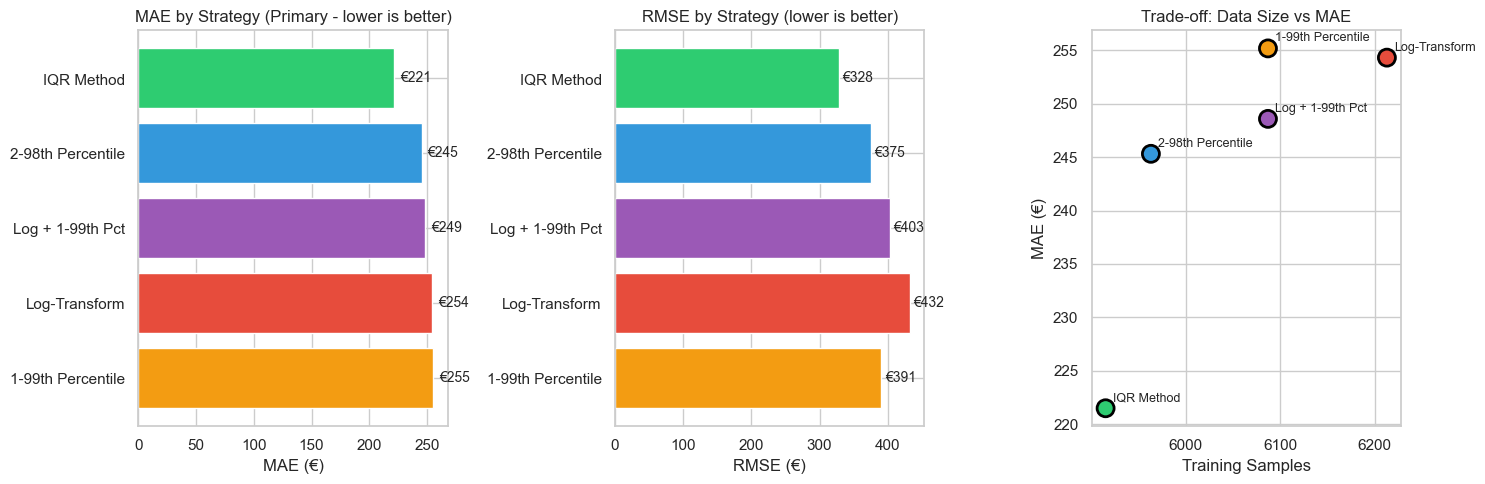


✓ Best performing strategy: IQR Method
  MAE: €221.48 (primary metric)
  RMSE: €327.99
  Training samples: 5,915


In [32]:
# Summary comparison table
print("\n" + "=" * 90)
print("PREPROCESSING STRATEGY COMPARISON SUMMARY")
print("=" * 90)

comparison_df = pd.DataFrame(results_preprocessing).T
comparison_df = comparison_df[['n_train', 'mae', 'rmse', 'r2', 'mape']]
comparison_df.columns = ['Train Samples', 'MAE (€)', 'RMSE (€)', 'R²', 'MAPE (%)']
comparison_df = comparison_df.sort_values('MAE (€)')  # Sort by MAE (primary)

print("\n")
display(comparison_df.round(2))

# Visualization
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

strategies = comparison_df.index.tolist()
colors = ['#2ecc71', '#3498db', '#9b59b6', '#e74c3c', '#f39c12']

# MAE comparison (primary - first)
ax = axes[0]
bars = ax.barh(strategies, comparison_df['MAE (€)'], color=colors[:len(strategies)])
ax.set_xlabel('MAE (€)')
ax.set_title('MAE by Strategy (Primary - lower is better)')
ax.invert_yaxis()
for i, v in enumerate(comparison_df['MAE (€)']):
    ax.text(v + 5, i, f'€{v:,.0f}', va='center', fontsize=10)

# RMSE comparison
ax = axes[1]
bars = ax.barh(strategies, comparison_df['RMSE (€)'], color=colors[:len(strategies)])
ax.set_xlabel('RMSE (€)')
ax.set_title('RMSE by Strategy (lower is better)')
ax.invert_yaxis()
for i, v in enumerate(comparison_df['RMSE (€)']):
    ax.text(v + 5, i, f'€{v:,.0f}', va='center', fontsize=10)

# Trade-off: Samples vs Performance (MAE)
ax = axes[2]
ax.scatter(comparison_df['Train Samples'], comparison_df['MAE (€)'], 
           s=150, c=colors[:len(strategies)], edgecolors='black', linewidths=2)
for i, strategy in enumerate(strategies):
    ax.annotate(strategy, (comparison_df.loc[strategy, 'Train Samples'], 
                           comparison_df.loc[strategy, 'MAE (€)']),
                xytext=(5, 5), textcoords='offset points', fontsize=9)
ax.set_xlabel('Training Samples')
ax.set_ylabel('MAE (€)')
ax.set_title('Trade-off: Data Size vs MAE')

plt.tight_layout()
plt.show()

# Recommendation
best_strategy = comparison_df.index[0]
print(f"\n✓ Best performing strategy: {best_strategy}")
print(f"  MAE: €{comparison_df.loc[best_strategy, 'MAE (€)']:,.2f} (primary metric)")
print(f"  RMSE: €{comparison_df.loc[best_strategy, 'RMSE (€)']:,.2f}")
print(f"  Training samples: {comparison_df.loc[best_strategy, 'Train Samples']:,.0f}")

## 7. Hyperparameter Tuning with Optuna

Tune CatBoost using the **best preprocessing strategy from the experiment above**.

**Optimization Target: MAE (Mean Absolute Error)** - More robust to outliers than RMSE.

Based on the comparison, we use the strategy with the lowest MAE for hyperparameter tuning.

In [33]:
# Skip HGB tuning - focusing only on CatBoost which performed best
study_hgb = None
print("Skipping HistGradientBoosting tuning - focusing on CatBoost")

Skipping HistGradientBoosting tuning - focusing on CatBoost


In [34]:
# Skip XGBoost tuning - focusing only on CatBoost which performed best
study_xgb = None
print("Skipping XGBoost tuning - focusing on CatBoost")

Skipping XGBoost tuning - focusing on CatBoost


In [35]:
# Hyperparameter tuning using the BEST preprocessing strategy from experiment
# Check if saved params exist to skip tuning

import json

OPTUNA_PARAMS_FILE = Path('../models/optuna_catboost_params.json')

# Try to load existing params
if OPTUNA_PARAMS_FILE.exists():
    print("=" * 60)
    print("LOADING SAVED OPTUNA PARAMS (skipping tuning)")
    print("=" * 60)
    
    with open(OPTUNA_PARAMS_FILE, 'r') as f:
        saved_data = json.load(f)
    
    catboost_best_params = saved_data['best_params']
    catboost_best_value = saved_data['best_value']
    
    print(f"Loaded from: {OPTUNA_PARAMS_FILE}")
    print(f"Best CatBoost params: {catboost_best_params}")
    print(f"Best CatBoost MAE: {catboost_best_value:,.2f}")
    
    # Create a mock study object for compatibility
    study_cat = type('Study', (), {'best_params': catboost_best_params, 'best_value': catboost_best_value})()
    
elif OPTUNA_AVAILABLE and CATBOOST_AVAILABLE:
    from catboost import CatBoostRegressor
    from optuna.samplers import TPESampler
    
    print("=" * 60)
    print("RUNNING OPTUNA HYPERPARAMETER TUNING")
    print("=" * 60)
    
    # Determine best strategy from experiment results (now based on MAE)
    comparison_df_mae = comparison_df.sort_values('MAE (€)')
    best_strategy = comparison_df_mae.index[0]
    print(f"Using best strategy from experiment: {best_strategy}")
    print(f"  MAE: €{comparison_df_mae.loc[best_strategy, 'MAE (€)']:,.2f}")
    
    # Select the appropriate training data based on best strategy
    if 'IQR' in best_strategy:
        X_tune_train = X_train_iqr
        y_tune_train = y_train_iqr
        X_tune_test = X_test_iqr
        y_tune_test = y_test_iqr
        print(f"  Using IQR-filtered data: {len(X_tune_train):,} training samples")
    elif '2-98' in best_strategy:
        X_tune_train = X_train_2_98
        y_tune_train = y_train_2_98
        X_tune_test = X_test_2_98
        y_tune_test = y_test_2_98
        print(f"  Using 2-98th percentile data: {len(X_tune_train):,} training samples")
    elif '1-99' in best_strategy and 'Log' not in best_strategy:
        X_tune_train = X_train_1_99
        y_tune_train = y_train_1_99
        X_tune_test = X_test_1_99
        y_tune_test = y_test_1_99
        print(f"  Using 1-99th percentile data: {len(X_tune_train):,} training samples")
    else:
        # Default to 1-99th
        X_tune_train = X_train_1_99
        y_tune_train = y_train_1_99
        X_tune_test = X_test_1_99
        y_tune_test = y_test_1_99
        print(f"  Using 1-99th percentile data (default): {len(X_tune_train):,} training samples")
    
    # Prepare CatBoost data for tuning
    X_tune_cb, _ = prepare_catboost_data(
        pd.concat([X_tune_train, y_tune_train], axis=1), 
        raw_numeric, raw_categorical, TARGET_COL
    )
    
    def objective_catboost(trial):
        """Objective for CatBoost hyperparameter optimization - OPTIMIZING MAE"""
        params = {
            'iterations': trial.suggest_int('iterations', 200, 800),
            'depth': trial.suggest_int('depth', 4, 10),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
            'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1.0, 10.0),
            'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 1.0),
            'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 30),
        }
        
        # Use MAE as loss function for CatBoost
        model = CatBoostRegressor(
            **params,
            loss_function='MAE',  # Optimize MAE directly
            cat_features=raw_categorical,
            random_seed=42,
            verbose=False
        )
        
        # Score using MAE
        scores = cross_val_score(
            model, X_tune_cb, y_tune_train,
            cv=3, scoring='neg_mean_absolute_error'  # Optimize for MAE
        )
        return -scores.mean()
    
    print("\nTuning CatBoost with Optuna (30 trials) - Optimizing MAE...")
    study_cat = optuna.create_study(direction='minimize', sampler=TPESampler(seed=42))
    study_cat.optimize(objective_catboost, n_trials=30, show_progress_bar=True)
    
    print(f"\nBest CatBoost params: {study_cat.best_params}")
    print(f"Best CatBoost MAE: {study_cat.best_value:,.2f}")
    
    # Save params for future runs
    OPTUNA_PARAMS_FILE.parent.mkdir(parents=True, exist_ok=True)
    with open(OPTUNA_PARAMS_FILE, 'w') as f:
        json.dump({
            'best_params': study_cat.best_params,
            'best_value': study_cat.best_value,
            'best_strategy': best_strategy,
        }, f, indent=2)
    print(f"\nSaved Optuna params to: {OPTUNA_PARAMS_FILE}")
    
else:
    study_cat = None
    print("CatBoost or Optuna not available")

[I 2025-12-09 21:21:08,894] A new study created in memory with name: no-name-a00a819b-4a47-41ee-9f84-eb3318baeb9c


RUNNING OPTUNA HYPERPARAMETER TUNING
Using best strategy from experiment: IQR Method
  MAE: €221.48
  Using IQR-filtered data: 5,915 training samples

Tuning CatBoost with Optuna (30 trials) - Optimizing MAE...


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2025-12-09 21:22:22,633] Trial 0 finished with value: 233.82131520323026 and parameters: {'iterations': 425, 'depth': 10, 'learning_rate': 0.1205712628744377, 'l2_leaf_reg': 6.387926357773329, 'bagging_temperature': 0.15601864044243652, 'min_data_in_leaf': 5}. Best is trial 0 with value: 233.82131520323026.
[I 2025-12-09 21:23:01,611] Trial 1 finished with value: 232.0697476625636 and parameters: {'iterations': 234, 'depth': 10, 'learning_rate': 0.07725378389307355, 'l2_leaf_reg': 7.372653200164409, 'bagging_temperature': 0.020584494295802447, 'min_data_in_leaf': 30}. Best is trial 1 with value: 232.0697476625636.
[I 2025-12-09 21:23:20,053] Trial 2 finished with value: 243.51639462171113 and parameters: {'iterations': 700, 'depth': 5, 'learning_rate': 0.01855998084649059, 'l2_leaf_reg': 2.650640588680904, 'bagging_temperature': 0.3042422429595377, 'min_data_in_leaf': 16}. Best is trial 1 with value: 232.0697476625636.
[I 2025-12-09 21:23:37,264] Trial 3 finished with value: 229.691

## 8. Ensemble Methods

Combine the best models using stacking or weighted averaging.

In [36]:
# Build tuned models
from sklearn.pipeline import Pipeline
from src.modeling import build_preprocessor

tuned_models = {}

# Tuned HGB
if study_hgb is not None:
    tuned_hgb = build_sklearn_pipeline(
        'hist_gradient_boosting',
        selected_numeric,
        selected_categorical,
        **study_hgb.best_params
    )
    tuned_models['HGB'] = tuned_hgb
else:
    tuned_models['HGB'] = build_sklearn_pipeline(
        'hist_gradient_boosting', selected_numeric, selected_categorical
    )

# Tuned XGBoost
if XGBOOST_AVAILABLE:
    from xgboost import XGBRegressor
    preprocessor = build_preprocessor(selected_numeric, selected_categorical)
    
    if study_xgb is not None:
        xgb_params = study_xgb.best_params
    else:
        xgb_params = {'n_estimators': 200, 'max_depth': 6, 'learning_rate': 0.1}
    
    tuned_xgb = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', XGBRegressor(**xgb_params, random_state=42, n_jobs=-1))
    ])
    tuned_models['XGB'] = tuned_xgb

# Random Forest (not tuned, but included for diversity)
tuned_models['RF'] = build_sklearn_pipeline('random_forest', selected_numeric, selected_categorical)

print(f"Prepared {len(tuned_models)} models for ensemble: {list(tuned_models.keys())}")

Prepared 3 models for ensemble: ['HGB', 'XGB', 'RF']


In [37]:
# Stacking Ensemble
print("=" * 60)
print("STACKING ENSEMBLE")
print("=" * 60)

# Create estimators list for stacking
estimators = [(name, model) for name, model in tuned_models.items()]

stacking_regressor = StackingRegressor(
    estimators=estimators,
    final_estimator=Ridge(alpha=1.0),
    cv=5,
    n_jobs=-1
)

# Compute ALL metrics via CV
stacking_mae_scores = cross_val_score(stacking_regressor, X_opt, y_train, cv=5, scoring='neg_mean_absolute_error')
stacking_rmse_scores = cross_val_score(stacking_regressor, X_opt, y_train, cv=5, scoring='neg_root_mean_squared_error')
stacking_r2_scores = cross_val_score(stacking_regressor, X_opt, y_train, cv=5, scoring='r2')

stacking_results = {
    'mae_mean': -stacking_mae_scores.mean(),
    'mae_std': stacking_mae_scores.std(),
    'rmse_mean': -stacking_rmse_scores.mean(),
    'rmse_std': stacking_rmse_scores.std(),
    'r2_mean': stacking_r2_scores.mean(),
    'r2_std': stacking_r2_scores.std(),
}

print(f"MAE:  {stacking_results['mae_mean']:,.2f} (+/- {stacking_results['mae_std']:,.2f}) [PRIMARY]")
print(f"RMSE: {stacking_results['rmse_mean']:,.2f} (+/- {stacking_results['rmse_std']:,.2f})")
print(f"R²:   {stacking_results['r2_mean']:.4f}")

STACKING ENSEMBLE
MAE:  309.16 (+/- 9.84) [PRIMARY]
RMSE: 493.92 (+/- 20.10)
R²:   0.7541


In [38]:
# Voting Ensemble (simple averaging)
print("=" * 60)
print("VOTING ENSEMBLE (Average)")
print("=" * 60)

voting_regressor = VotingRegressor(
    estimators=estimators,
    n_jobs=-1
)

# Compute ALL metrics via CV
voting_mae_scores = cross_val_score(voting_regressor, X_opt, y_train, cv=5, scoring='neg_mean_absolute_error')
voting_rmse_scores = cross_val_score(voting_regressor, X_opt, y_train, cv=5, scoring='neg_root_mean_squared_error')
voting_r2_scores = cross_val_score(voting_regressor, X_opt, y_train, cv=5, scoring='r2')

voting_results = {
    'mae_mean': -voting_mae_scores.mean(),
    'mae_std': voting_mae_scores.std(),
    'rmse_mean': -voting_rmse_scores.mean(),
    'rmse_std': voting_rmse_scores.std(),
    'r2_mean': voting_r2_scores.mean(),
    'r2_std': voting_r2_scores.std(),
}

print(f"MAE:  {voting_results['mae_mean']:,.2f} (+/- {voting_results['mae_std']:,.2f}) [PRIMARY]")
print(f"RMSE: {voting_results['rmse_mean']:,.2f} (+/- {voting_results['rmse_std']:,.2f})")
print(f"R²:   {voting_results['r2_mean']:.4f}")

VOTING ENSEMBLE (Average)
MAE:  308.97 (+/- 11.25) [PRIMARY]
RMSE: 497.04 (+/- 19.68)
R²:   0.7510


In [39]:
# Add ensemble results to comparison
all_results['Stacking Ensemble'] = stacking_results
all_results['Voting Ensemble'] = voting_results

# Final comparison - sort by MAE
final_comparison = compare_models(all_results)
final_comparison = final_comparison.sort_values('mae_mean')

print("\n" + "=" * 80)
print("FINAL MODEL COMPARISON (sorted by MAE - primary metric)")
print("=" * 80)
display(final_comparison)


FINAL MODEL COMPARISON (sorted by MAE - primary metric)


,Model,rmse_mean,rmse_std,mae_mean,mae_std,r2_mean,r2_std
3,CatBoost,503.00,18.00,294.28,5.53,0.74,0.01
2,Voting Ensemble,497.04,19.68,308.97,11.25,0.75,0.01
0,Stacking Ensemble,493.92,20.10,309.16,9.84,0.75,0.01
1,XGBoost,496.56,20.29,312.78,10.03,0.75,0.01
7,Random Forest,520.20,18.53,317.36,10.21,0.73,0.01
5,LightGBM,514.50,20.02,323.56,11.77,0.73,0.01
6,HistGradientBoosting,517.58,21.88,324.74,13.89,0.73,0.01
4,Ridge,512.29,19.72,329.87,10.05,0.74,0.01


## 9. Final Model Training and Evaluation

In [45]:
# Select best model based on MAE (primary metric)
best_model_name = final_comparison.iloc[0]['Model']
print(f"Best model (lowest MAE): {best_model_name}")

# Use IQR data (best preprocessing strategy from Section 6.1)
print(f"Using IQR-filtered data for final training")

# Train best model on IQR data
if 'Stacking' in best_model_name:
    final_model = stacking_regressor
    final_model.fit(X_opt, y_train)
    y_pred = final_model.predict(X_opt_test)
    final_metrics = evaluate_predictions(y_test, y_pred)
    y_actual = y_test
elif 'Voting' in best_model_name:
    final_model = voting_regressor
    final_model.fit(X_opt, y_train)
    y_pred = final_model.predict(X_opt_test)
    final_metrics = evaluate_predictions(y_test, y_pred)
    y_actual = y_test
elif 'CatBoost' in best_model_name and CATBOOST_AVAILABLE:
    # Prepare IQR-filtered CatBoost data
    X_final_cb, _ = prepare_catboost_data(
        pd.concat([X_train_iqr, y_train_iqr], axis=1),
        raw_numeric, raw_categorical, TARGET_COL
    )
    X_final_test_cb, _ = prepare_catboost_data(
        pd.concat([X_test_iqr, y_test_iqr], axis=1),
        raw_numeric, raw_categorical, TARGET_COL
    )

    if study_cat is not None:
        final_model = CatBoostRegressor(
            **study_cat.best_params,
            loss_function='MAE',
            cat_features=raw_categorical,
            random_seed=42,
            verbose=False
        )
    else:
        final_model = CatBoostRegressor(
            iterations=300,
            depth=6,
            learning_rate=0.1,
            loss_function='MAE',
            cat_features=raw_categorical,
            random_seed=42,
            verbose=False
        )

    final_model.fit(X_final_cb, y_train_iqr)
    y_pred = final_model.predict(X_final_test_cb)
    final_metrics = evaluate_predictions(y_test_iqr, y_pred)
    y_actual = y_test_iqr  # For visualization
elif best_model_name in tuned_models:
    final_model = tuned_models[best_model_name]
    final_model.fit(X_opt, y_train)
    y_pred = final_model.predict(X_opt_test)
    final_metrics = evaluate_predictions(y_test, y_pred)
    y_actual = y_test
else:
    final_model = tuned_models.get('HGB', build_sklearn_pipeline(
        'hist_gradient_boosting', selected_numeric, selected_categorical
    ))
    final_model.fit(X_opt, y_train)
    y_pred = final_model.predict(X_opt_test)
    final_metrics = evaluate_predictions(y_test, y_pred)
    y_actual = y_test

print(f"\n=== Test Set Performance")
print(f"MAE:  {final_metrics['mae']:,.2f} (primary metric)")
print(f"RMSE: {final_metrics['rmse']:,.2f}")
print(f"R²:   {final_metrics['r2']:.4f}")
print(f"MAPE: {final_metrics['mape']:.2f}%")

Best model (lowest MAE): CatBoost
Using IQR-filtered data for final training

=== Test Set Performance
MAE:  215.22 (primary metric)
RMSE: 335.54
R²:   0.7850
MAPE: 18.68%


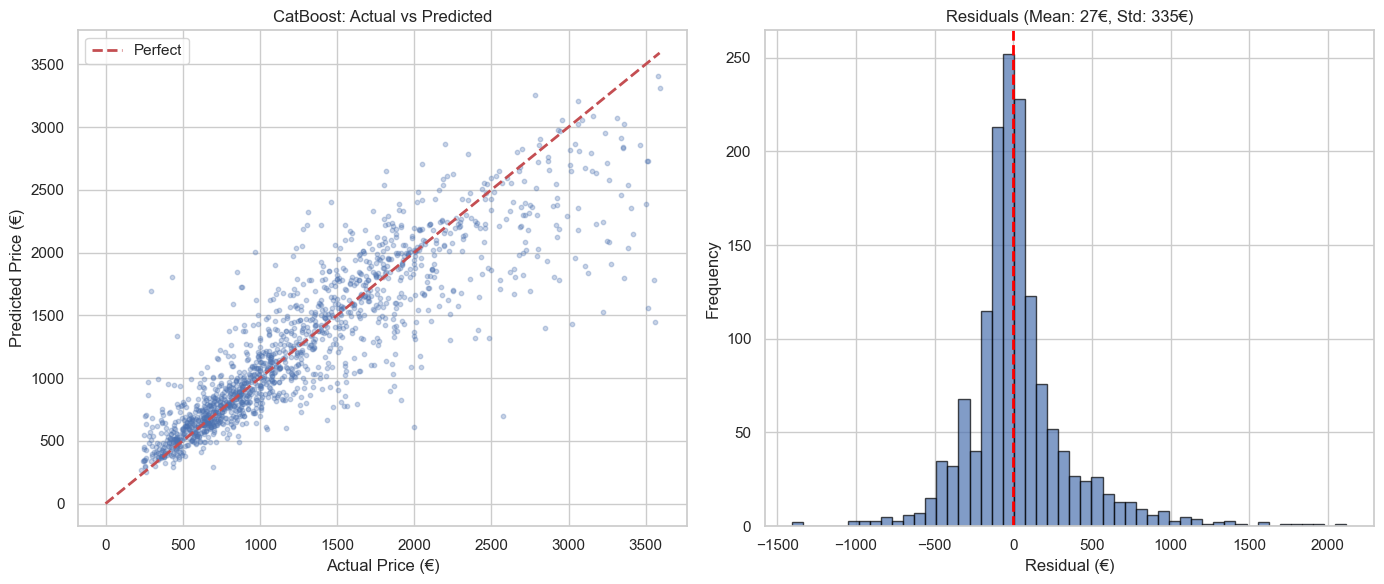

In [41]:
# Prediction visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# y_actual is already set in the previous cell based on model type

# Actual vs Predicted
ax = axes[0]
ax.scatter(y_actual, y_pred, alpha=0.3, s=10)
ax.plot([0, y_actual.max()], [0, y_actual.max()], 'r--', lw=2, label='Perfect')
ax.set_xlabel('Actual Price (€)')
ax.set_ylabel('Predicted Price (€)')
ax.set_title(f'{best_model_name}: Actual vs Predicted')
ax.legend()

# Residuals
ax = axes[1]
residuals = y_actual - y_pred
ax.hist(residuals, bins=50, edgecolor='black', alpha=0.7)
ax.axvline(0, color='red', linestyle='--', lw=2)
ax.set_xlabel('Residual (€)')
ax.set_ylabel('Frequency')
ax.set_title(f'Residuals (Mean: {residuals.mean():,.0f}€, Std: {residuals.std():,.0f}€)')

plt.tight_layout()
plt.show()

## 10. Save Optimized Model

In [42]:
# Save metadata about feature selection and tuning
metadata = {
    'model_type': best_model_name,
    'feature_cols': top_features_list,
    'numeric_cols': selected_numeric,
    'categorical_cols': selected_categorical,
    'target_col': TARGET_COL,
    'test_metrics': final_metrics,
    'n_features_original': len(feature_cols),
    'n_features_selected': len(top_features_list),
    'tuning_performed': OPTUNA_AVAILABLE,
}

# Add tuning params if available
if study_hgb is not None:
    metadata['hgb_best_params'] = study_hgb.best_params
if study_xgb is not None:
    metadata['xgb_best_params'] = study_xgb.best_params
if study_cat is not None:
    metadata['catboost_best_params'] = study_cat.best_params

save_model(final_model, '../models/price_model_optimized.pkl', metadata)

print("\nModel saved with metadata:")
for key, value in metadata.items():
    if isinstance(value, list):
        print(f"  {key}: {len(value)} items")
    elif isinstance(value, dict):
        print(f"  {key}: {len(value)} params")
    else:
        print(f"  {key}: {value}")

Model saved to: ../models/price_model_optimized.pkl

Model saved with metadata:
  model_type: CatBoost
  feature_cols: 30 items
  numeric_cols: 9 items
  categorical_cols: 21 items
  target_col: _precio_num
  test_metrics: 4 params
  n_features_original: 62
  n_features_selected: 30
  tuning_performed: True
  catboost_best_params: 6 params


In [43]:
# Also save the lite model (user-friendly features only)
if len(lite_features) > 0:
    print("\n=== Training and Saving Lite Model ===")

    # Apply IQR filtering to lite model data (use same IQR thresholds)
    lite_train_mask = y_train_full.index.isin(y_train_iqr.index)
    lite_test_mask = y_test_full.index.isin(y_test_iqr.index)

    X_train_lite_iqr = X_train_full.loc[lite_train_mask, lite_features]
    y_train_lite_iqr = y_train_full[lite_train_mask]
    X_test_lite_iqr = X_test_full.loc[lite_test_mask, lite_features]
    y_test_lite_iqr = y_test_full[lite_test_mask]

    lite_model = build_sklearn_pipeline('hist_gradient_boosting', lite_numeric, lite_categorical)
    lite_model.fit(X_train_lite_iqr, y_train_lite_iqr)

    y_pred_lite = lite_model.predict(X_test_lite_iqr)
    lite_metrics = evaluate_predictions(y_test_lite_iqr, y_pred_lite)

    lite_metadata = {
        'model_type': 'HistGradientBoosting (Lite)',
        'feature_cols': lite_features,
        'numeric_cols': lite_numeric,
        'categorical_cols': lite_categorical,
        'target_col': TARGET_COL,
        'test_metrics': lite_metrics,
        'description': 'User-friendly features only (no benchmark lookups), IQR filtered',
    }

    save_model(lite_model, '../models/price_model_lite.pkl', lite_metadata)

    print(f"\nLite Model Performance (IQR data):")
    print(f"  MAE:  {lite_metrics['mae']:,.2f}")
    print(f"  RMSE: {lite_metrics['rmse']:,.2f}")
    print(f"  R²:   {lite_metrics['r2']:.4f}")


=== Training and Saving Lite Model ===
Model saved to: ../models/price_model_lite.pkl

Lite Model Performance (IQR data):
  MAE:  276.18
  RMSE: 390.72
  R²:   0.7085


## Summary

### Optimization Results

1. **Feature Selection**: Reduced features from original count to top N based on permutation importance
2. **Additional Models**: Compared XGBoost, LightGBM with existing models
3. **Hyperparameter Tuning**: Used Optuna to tune top models (optimizing **MAE**)
4. **Ensemble Methods**: Tested Stacking and Voting ensembles

### Primary Metric: MAE (Mean Absolute Error)

We chose MAE as the primary metric because:
- More robust to outliers than RMSE
- Easier to interpret (average error in euros)
- Better reflects typical prediction error

All metrics are still computed: MAE > RMSE > R² > MAPE

### Models Saved

1. `models/price_model_optimized.pkl` - Best performing model (optimized for MAE)
2. `models/price_model_lite.pkl` - User-friendly model (no benchmark lookups needed)

### User Input Features (Lite Model)

**Easy to provide:**
- RAM (GB)
- SSD (GB)
- Brand
- Screen size (inches)
- Weight (kg)

**Dropdown/selection:**
- CPU brand & family
- GPU brand & series
- Screen technology (OLED, IPS, etc.)

### Next Steps

1. Deploy models via API
2. Create user interface with dropdowns for categorical features
3. Implement CPU/GPU name → benchmark lookup for full model